# AirBnB Data Exploration


In [31]:
# import libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
from helpers import price_parse, fit_prepare, valid_value_intbool

In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

## Load and Pre-Process

In [33]:
# read data files
# Boston
#b_cal = pd.read_csv('data/boston/calendar.csv', sep=',', header=0, 
#                    parse_dates=['date',], 
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'],
#                    converters={'price': price_parse})
b_lis = pd.read_csv('data/boston/listings.csv', sep=',', header=0, 
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated', 
                                 'calendar_last_scraped', 'first_review', 'last_review'], 
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse, 
                                'monthly_price': price_parse, 'security_deposit': price_parse, 
                                'cleaning_fee': price_parse, 'extra_people': price_parse},
                    true_values=['t'], false_values=['f'])
#b_rev = pd.read_csv('data/boston/reviews.csv', sep=',', header=0, 
#                    parse_dates=['date',],  
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'])
#Seattle
#s_cal = pd.read_csv('data/seattle/calendar.csv', sep=',', header=0, 
#                    parse_dates=['date',],  
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'],
#                    converters={'price': price_parse})
s_lis = pd.read_csv('data/seattle/listings.csv', sep=',', header=0,
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated', 
                                 'calendar_last_scraped', 'first_review', 'last_review'],  
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse, 
                                'monthly_price': price_parse, 'security_deposit': price_parse, 
                                'cleaning_fee': price_parse, 'extra_people': price_parse},
                    true_values=['t'], false_values=['f'])
#s_rev = pd.read_csv('data/seattle/reviews.csv', sep=',', header=0, 
#                    parse_dates=['date',],  
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'])
#Berlin
#ber_cal = pd.read_csv('data/berlin/calendar_summary.csv', sep=',', header=0, 
#                    parse_dates=['date',], 
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'],
#                    converters={'price': price_parse})
ber_lis = pd.read_csv('data/berlin/listings_summary.csv', sep=',', header=0, 
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated', 
                                 'calendar_last_scraped', 'first_review', 'last_review'], 
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse, 
                                'monthly_price': price_parse, 'security_deposit': price_parse, 
                                'cleaning_fee': price_parse, 'extra_people': price_parse},
                    true_values=['t'], false_values=['f'])
#ber_rev = pd.read_csv('data/berlin/reviews_summary.csv', sep=',', header=0, 
#                    parse_dates=['date',],  
#                    infer_datetime_format=True,
#                    true_values=['t'], false_values=['f'])

C:\Users\ruindur\.conda\envs\airbnb_blog\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (28,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
# join tables, all-missing columns
#calendar = pd.concat([b_cal, s_cal, ber_cal], axis=0, ignore_index=True, sort=False).dropna(how='all', axis=1)
listings = pd.concat([b_lis.assign(**{'source': lambda x: 'Boston'}), 
                      s_lis.assign(**{'source': lambda x: 'Seattle'}),
                      ber_lis.assign(**{'source': lambda x: 'Berlin'})], axis=0, 
                     ignore_index=True, sort=False).dropna(how='all', axis=1)
#reviews = pd.concat([b_rev, s_rev, ber_rev], axis=0, ignore_index=True, sort=False).dropna(how='all', axis=1)

In [35]:
# column categories
listings_categorical = ['experiences_offered', 'host_location', 'host_response_time', 
                        'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 
                        'state', 'zipcode', 'market', 'source', 'smart_location', 
                        'property_type', 'cancellation_policy',
                        'room_type', 'bed_type', 'calendar_updated', 'jurisdiction_names']
listings_presence = []
listings_text = ['name', 'summary', 'space', 'description', 'notes', 'neighborhood_overview', 
                 'transit', 'host_about', 'host_name', 'street', 'neighborhood']
listings_multi_categories = ['host_verifications', 'amenities']
listings_numeric = listings.select_dtypes('number').columns

In [36]:
for col in listings_numeric:
    print(listings[col].value_counts())

8849407     1
9866909     1
12162808    1
7956227     1
8216321     1
           ..
26409335    1
114763      1
8303683     1
18699138    1
10749953    1
Name: id, Length: 29955, dtype: int64
20181107122246    22552
20160104002432     3818
20160906204935     3585
Name: scrape_id, dtype: int64
30283594     138
25188         79
4962900       64
9419684       61
12243051      58
            ... 
148479451      1
158606993      1
14348964       1
132774565      1
10420224       1
Name: host_id, Length: 24107, dtype: int64
1.0       19948
2.0        4519
3.0        1519
4.0         753
5.0         459
6.0         320
7.0         264
9.0         143
8.0         138
749.0       136
11.0        136
12.0        120
19.0         96
18.0         88
10.0         80
558.0        79
34.0         67
17.0         61
313.0        61
14.0         59
363.0        58
37.0         57
30.0         54
16.0         52
15.0         51
52.0         50
13.0         48
24.0         48
48.0         46
59.0        

In [37]:
# actual URLs are not interesting, but presence could be of value
for col in listings.columns:
    if 'url' in col:
        pcol = 'has_' + col
        listings[pcol] = listings[col].apply(valid_value_intbool, convert_dtype=True)
        listings.drop(col, axis=1, inplace=True)
        listings_presence.append(pcol)

In [38]:
listings_all_same = []
for col in listings_categorical:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_categorical.remove(col)  

for col in listings_presence:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_presence.remove(col)  

for col in listings_numeric:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_numeric.remove(col)  
        
listings = listings.drop(listings_all_same, axis=1)
listings.sample(10)

,id,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,...,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,source,is_business_travel_ready,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
25157,23474140,20181107122246,2018-11-07,16m2 - Cozy room in quiet neighborhood of Berlin,"Nice cozy room, located in a quiet residential...",NaN,"Nice cozy room, located in a quiet residential...",NaN,NaN,NaN,...,False,2,NaN,Berlin,False,1,1,1,1,1
12466,7553270,20181107122246,2018-11-07,BIG ROOM IN MITTE FOR 2 PERSONS,"Hey guys, I'm renting my big room in a central...",My flat is located in the very center of Berli...,"Hey guys, I'm renting my big room in a central...",NaN,NaN,NaN,...,False,2,0.03,Berlin,False,1,1,1,1,1
29295,29096509,20181107122246,2018-11-07,Stay with a local near bars and 18 min. to centre,Stay with a local Berliner with a lot of couch...,You DON'T get any luxury here in terms of the ...,Stay with a local Berliner with a lot of couch...,It's a neighborhood that is close to the bars ...,FREE BREAKFAST will be provided. Please let me...,"There are subways (U5), S-trains (S41 & S42 Ri...",...,False,2,4.00,Berlin,False,1,1,1,1,1
4171,7462439,20160104002432,2016-01-04,"Capitol Hill Apt, Magnificent Views",Spacious sun porch with magnificent view of th...,"Wood floors, big windows, new kitchen applianc...",Spacious sun porch with magnificent view of th...,Capitol Hill is the place to be. The apartment...,"Gay friendly, 420 friendly (outside)",There is plenty of street parking and bus line...,...,False,1,0.18,Seattle,NaN,1,1,1,1,1
18052,16066804,20181107122246,2018-11-07,"Cozy room, 20 min Alexander Platz, Prenzlauer ...",The apartment is located in a pretty good area...,"It's a cozy nice place to stay, only 2 min awa...",The apartment is located in a pretty good area...,"The house is located in a central area, 2 min'...","A nice kitty is living here as well, but she i...",S Prenzlauer Allee (Ring Bhan) open till 1:00 ...,...,False,1,0.21,Berlin,False,1,1,1,1,1
22097,20634992,20181107122246,2018-11-07,Cozy Room next to tempelhofer feld,"The room got a double bed, a desk for a laptop...",You got a room in a small shared living aparte...,"The room got a double bed, a desk for a laptop...",Die Nachbarschaft ist mit dem direkten Anschlu...,"Smoking is not allowed in the apartement, but ...",Öffentliche Verkehrsmittel: U Leinestr. ( U8 )...,...,False,2,0.23,Berlin,False,1,1,1,1,1
11653,6605484,20181107122246,2018-11-07,INDUSTRIE-LOFT in Kreuzkölln,Wir vermieten ausnahmsweise für einige Zeit (A...,Das Industrieloft mit insgesamt 150qm befindet...,Wir vermieten ausnahmsweise für einige Zeit (A...,Kreuzkölln ist derzeit the place to be wenn ma...,RAUCHEN: Unser Loft ist ein Nichraucherloft . ...,"U8, U7, M59, M29",...,False,1,0.19,Berlin,False,1,1,1,1,1
24425,22700870,20181107122246,2018-11-07,"Big, cozy and well communicated room in F'shain","Very bright, cozy and modern room, well commun...","The room is a wide, bright and cozy double roo...","Very bright, cozy and modern room, well commun...",It is a very quiet and residential neighborhoo...,The apartment is inside a big and tall buildin...,SBahn Storkower Strasse station is 2 min walk ...,...,False,1,0.72,Berlin,False,1,1,1,1,1
27356,26651462,20181107122246,2018-11-07,Schönes 2 Personen Loft im Prenzlauer Kiez,Ich heiße Sie herzlich willkommen in meinem sc...,NaN,Ich heiße Sie herzlich willkommen in meinem sc...,NaN,NaN,S Bahn Bornholmer Straße oder S Bahn Schönhau...,...,False,1,0.54,Berlin,False,1,1,1,1,1
2169,14043390,20160906204935,2016-09-07,best location best price绝佳地段价格优惠,My comfortable one bedroom apartment with one ...,NaN,My comfortable one bedroom apartment with one ...,NaN,NaN,NaN,...,False,1,2.26,Boston,NaN,1,1,1,1,1


In [39]:
for col in listings.columns:
    if '_id' in col or '_url' in col:
        print(col)

scrape_id
host_id
host_identity_verified
has_thumbnail_url
has_medium_url
has_xl_picture_url
has_host_thumbnail_url
has_host_picture_url


In [40]:
# convert boolean columns to integer
boolcol = listings.select_dtypes('bool').columns
for col in boolcol:
    listings[col] = listings[col].apply(lambda x: int(x))
#boolcol = calendar.select_dtypes('bool').columns
#for col in boolcol:
#    calendar[col] = calendar[col].apply(lambda x: int(x))
#boolcol = reviews.select_dtypes('bool').columns
#for col in boolcol:
#    reviews[col] = reviews[col].apply(lambda x: int(x))

## Tables Overview

In [41]:
#sns.pairplot(listings, vars=listings_numeric)

In [42]:
#sns.pairplot(calendar)#

In [43]:
#sns.pairplot(listings, vars=listings_numeric, kind='reg')

In [44]:
X, y = fit_prepare(listings, 'review_scores_rating', listings_numeric, listings_categorical, listings_presence)
X.drop([col for col in X.columns if 'review_scores' in col], inplace=True, axis=1)
print(X['source_Seattle'].value_counts())
X.sample(10)

0    20935
1     3171
Name: source_Seattle, dtype: int64


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calendar_updated_never,calendar_updated_today,calendar_updated_yesterday,calendar_updated_nan,jurisdiction_names_nan,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
23903,22206885,20181107122246,44866580,1.0,1.0,52.436510,13.278643,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
17771,15603508,20181107122246,5386105,1.0,1.0,52.451004,13.319178,1,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
13633,8966046,20181107122246,17450447,2.0,2.0,52.501364,13.443540,8,1.0,3.0,...,0,0,0,0,1,1,1,1,1,1
19944,18515849,20181107122246,13354469,1.0,1.0,52.523663,13.450006,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
27340,26630740,20181107122246,22169045,1.0,1.0,52.559425,13.386171,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
26330,25003493,20181107122246,78431703,1.0,1.0,52.494052,13.424429,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
15257,11566528,20181107122246,1929820,1.0,1.0,52.516607,13.445520,3,1.0,2.0,...,0,0,1,0,1,1,1,1,1,1
17019,14298327,20181107122246,20029104,1.0,1.0,52.557555,13.465755,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
11999,7058758,20181107122246,12541677,1.0,1.0,52.473026,13.453294,3,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
9366,2761128,20181107122246,14121873,1.0,1.0,52.485138,13.390073,6,1.5,3.0,...,0,0,0,0,1,1,1,1,1,1


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 * 42)

pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
alphas = np.logspace(-7, -1, 16)

PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)

In [46]:
pcvf = PCV.fit(X_train, y_train)
#pcvf = PCV.fit(X, y)

In [47]:
pcvf.best_params_

{'model__alpha': 0.1}

In [48]:
esti = pcvf.best_estimator_
print('train score: {}  | test score: {}'.format(esti.score(X_train, y_train), esti.score(X_test, y_test)))

train score: 0.22579558148621026  | test score: -0.003127172660233102


In [49]:
coeff = esti.steps[-1][1].coef_

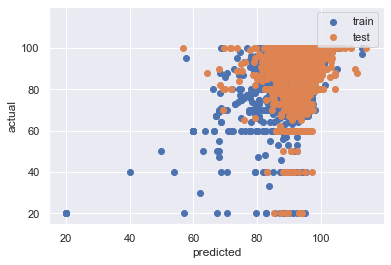

In [50]:
plt.scatter(esti.predict(X_train), y_train, label='train')
plt.scatter(esti.predict(X_test), y_test, label='test')
limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
latitude,13.163913,13.163913
state_Berlin,3.956574,3.956574
"host_location_Berlin, Berlin, Germany",2.802919,2.802919
scrape_id,-1.950315,1.950315
neighbourhood_group_cleansed_nan,1.924221,1.924221
state_MA,1.924221,1.924221
source_Boston,1.924221,1.924221
city_Boston,1.853929,1.853929
"smart_location_Boston, MA",1.853929,1.853929
calculated_host_listings_count,-1.796771,1.796771


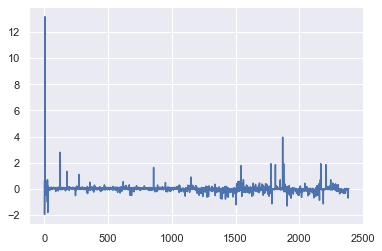

In [51]:
plt.plot(coeff)
coeff_vals = pd.DataFrame(coeff, index=X.columns, columns=['coefficient'])
coeff_vals['coefficient_abs']=np.abs(coeff_vals['coefficient'])
coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [52]:
X_sea = X[X['source_Seattle'] == 1]
y_sea = y.loc[X_sea.index]
X_bos = X[X['source_Boston'] == 1]
y_bos = y.loc[X_bos.index]
X_ber = X[X['source_Boston'] == X['source_Seattle']]
y_ber = y.loc[X_ber.index]
print(X_sea.shape, y_sea.shape, X_bos.shape, y_bos.shape, X_ber.shape, y_ber.shape)

(3171, 2390) (3171,) (2772, 2390) (2772,) (18163, 2390) (18163,)


{'model__alpha': 0.1}
Seattle:: train score: 0.2942399327103503  | test score: 0.015741458094922556
Boston::  train score: 0.37432183595662627  | test score: -0.08091547309927605
Berlin::  train score: 0.20243423390373816  | test score: -0.08010662897339871


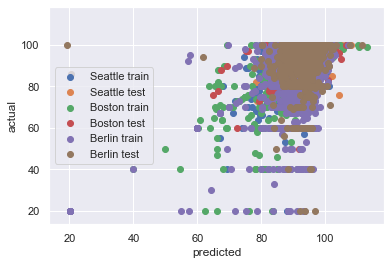

In [53]:
X_sea_train, X_sea_test, y_sea_train, y_sea_test = train_test_split(X_sea, y_sea, test_size=0.1, random_state=23 * 42)
sea_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=0.001))
])

sea_PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)
sea_PCV_f = sea_PCV.fit(X_sea_train, y_sea_train)
print(sea_PCV_f.best_params_)

X_bos_train, X_bos_test, y_bos_train, y_bos_test = train_test_split(X_bos, y_bos, test_size=0.1, random_state=23 * 42)
bos_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=sea_PCV_f.best_params_['model__alpha']))
])

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(X_ber, y_ber, test_size=0.1, random_state=23 * 42)
ber_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=sea_PCV_f.best_params_['model__alpha']))
])


sea_pipeline.fit(X_sea_train, y_sea_train)
print('Seattle:: train score: {}  | test score: {}'.format(sea_pipeline.score(X_sea_train, y_sea_train), sea_pipeline.score(X_sea_test, y_sea_test)))

bos_pipeline.fit(X_bos_train, y_bos_train)
print('Boston::  train score: {}  | test score: {}'.format(bos_pipeline.score(X_bos_train, y_bos_train), bos_pipeline.score(X_bos_test, y_bos_test)))

ber_pipeline.fit(X_ber_train, y_ber_train)
print('Berlin::  train score: {}  | test score: {}'.format(ber_pipeline.score(X_ber_train, y_ber_train), ber_pipeline.score(X_ber_test, y_ber_test)))

plt.scatter(sea_pipeline.predict(X_sea_train), y_sea_train, label='Seattle train')
plt.scatter(sea_pipeline.predict(X_sea_test), y_sea_test, label='Seattle test')
plt.scatter(bos_pipeline.predict(X_bos_train), y_bos_train, label='Boston train')
plt.scatter(bos_pipeline.predict(X_bos_test), y_bos_test, label='Boston test')
plt.scatter(ber_pipeline.predict(X_ber_train), y_ber_train, label='Berlin train')
plt.scatter(ber_pipeline.predict(X_ber_test), y_ber_test, label='Berlin test')

limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
calculated_host_listings_count,-1.500606,1.500606
availability_60,-1.486744,1.486744
host_neighbourhood_Fenway/Kenmore,-1.168987,1.168987
price,1.088717,1.088717
availability_90,1.080238,1.080238
host_neighbourhood_Eastlake,1.001407,1.001407
host_response_rate_40%,-0.992503,0.992503
zipcode_98199,0.978281,0.978281
neighbourhood_cleansed_Eastlake,-0.956843,0.956843
zipcode_98121,-0.803424,0.803424


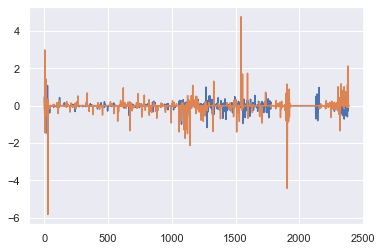

In [54]:
plt.plot(sea_pipeline.steps[-1][-1].coef_, label='Seattle')
plt.plot(bos_pipeline.steps[-1][-1].coef_, label='Boston')
sea_coeff_vals = pd.DataFrame(sea_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
sea_coeff_vals['coefficient_abs']=np.abs(sea_coeff_vals['coefficient'])
sea_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [55]:
bos_coeff_vals = pd.DataFrame(bos_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
bos_coeff_vals['coefficient_abs']=np.abs(bos_coeff_vals['coefficient'])
bos_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
calculated_host_listings_count,-5.831863,5.831863
neighbourhood_cleansed_Charlestown,4.772875,4.772875
zipcode_02129,-4.436439,4.436439
host_total_listings_count,2.986978,2.986978
host_listings_count,2.986978,2.986978
zipcode_02128,-2.701517,2.701517
host_acceptance_rate_45%,-2.131560,2.131560
calendar_updated_today,2.131516,2.131516
host_response_rate_79%,-1.748207,1.748207
neighbourhood_cleansed_Hyde Park,1.739552,1.739552


In [56]:
ber_coeff_vals = pd.DataFrame(ber_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
ber_coeff_vals['coefficient_abs']=np.abs(ber_coeff_vals['coefficient'])
ber_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
"host_location_Berlin, Berlin, Germany",2.335167,2.335167
zipcode_12524,2.116516,2.116516
latitude,1.968155,1.968155
neighbourhood_cleansed_Altglienicke,-1.796077,1.796077
host_neighbourhood_nan,-1.440220,1.440220
host_location_DE,1.320714,1.320714
neighbourhood_cleansed_Bohnsdorf,-1.236629,1.236629
host_neighbourhood_Neukölln,-1.073800,1.073800
property_type_Apartment,1.055109,1.055109
host_neighbourhood_Prenzlauer Berg,-1.021524,1.021524


In [57]:
listings['neighbourhood_cleansed'].value_counts()

Tempelhofer Vorstadt        1325
Frankfurter Allee Süd FK    1282
Alexanderplatz              1091
Reuterstraße                1002
Rixdorf                      880
                            ... 
Allende-Viertel                3
Neu-Hohenschönhausen Süd       2
Roxhill                        2
MV 2                           1
Hellersdorf-Ost                1
Name: neighbourhood_cleansed, Length: 247, dtype: int64

In [58]:
listings['neighbourhood_cleansed'].value_counts()

Tempelhofer Vorstadt        1325
Frankfurter Allee Süd FK    1282
Alexanderplatz              1091
Reuterstraße                1002
Rixdorf                      880
                            ... 
Allende-Viertel                3
Neu-Hohenschönhausen Süd       2
Roxhill                        2
MV 2                           1
Hellersdorf-Ost                1
Name: neighbourhood_cleansed, Length: 247, dtype: int64

In [59]:
X, y = fit_prepare(listings, 'review_scores_rating', listings_numeric, listings_categorical, listings_presence)
X.drop([col for col in X.columns if 'review_scores' in col], inplace=True, axis=1)
print(X['source_Seattle'].value_counts())
X.sample(10)

0    20935
1     3171
Name: source_Seattle, dtype: int64


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calendar_updated_never,calendar_updated_today,calendar_updated_yesterday,calendar_updated_nan,jurisdiction_names_nan,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
9272,2573342,20181107122246,12725295,1.0,1.0,52.501482,13.423291,2,2.0,1.0,...,0,0,0,0,1,1,1,1,1,1
28785,28455588,20181107122246,1177232,2.0,2.0,52.519154,13.458612,1,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
6651,7638689,20160104002432,5137566,1.0,1.0,47.683665,-122.370858,6,1.0,2.0,...,0,0,0,0,0,1,1,1,1,1
18768,17002284,20181107122246,113010563,1.0,1.0,52.479548,13.362635,4,1.0,2.0,...,0,0,0,0,1,1,1,1,1,1
267,14428514,20160906204935,22475241,1.0,1.0,42.307311,-71.103397,1,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
20528,19156648,20181107122246,77202130,1.0,1.0,52.530725,13.467069,2,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
11421,6275365,20181107122246,32607161,1.0,1.0,52.514619,13.398147,2,1.5,1.0,...,0,0,0,0,1,1,1,1,1,1
2652,1327725,20160906204935,7205617,1.0,1.0,42.345668,-71.139219,4,1.0,2.0,...,0,0,0,0,1,1,1,1,1,1
21156,19806978,20181107122246,5889788,2.0,2.0,52.485475,13.444174,4,1.0,1.0,...,0,0,0,0,1,1,1,1,1,1
27616,26948082,20181107122246,142029222,1.0,1.0,52.558464,13.393645,2,1.0,1.0,...,0,1,0,0,1,1,1,1,1,1


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 * 42)

pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
alphas = np.logspace(-7, -1, 16)

PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)

In [61]:
pcvf = PCV.fit(X_train, y_train)
#pcvf = PCV.fit(X, y)

In [62]:
pcvf.best_params_

{'model__alpha': 0.1}

In [63]:
esti = pcvf.best_estimator_
print('train score: {}  | test score: {}'.format(esti.score(X_train, y_train), esti.score(X_test, y_test)))

train score: 0.22579558148621026  | test score: -0.003127172660233102


In [64]:
coeff = esti.steps[-1][1].coef_

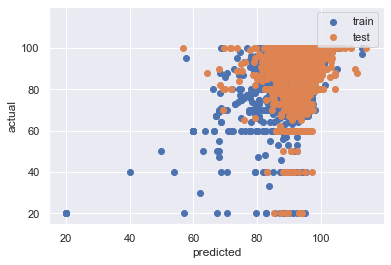

In [65]:
plt.scatter(esti.predict(X_train), y_train, label='train')
plt.scatter(esti.predict(X_test), y_test, label='test')
limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
latitude,13.163913,13.163913
state_Berlin,3.956574,3.956574
"host_location_Berlin, Berlin, Germany",2.802919,2.802919
scrape_id,-1.950315,1.950315
neighbourhood_group_cleansed_nan,1.924221,1.924221
state_MA,1.924221,1.924221
source_Boston,1.924221,1.924221
city_Boston,1.853929,1.853929
"smart_location_Boston, MA",1.853929,1.853929
calculated_host_listings_count,-1.796771,1.796771


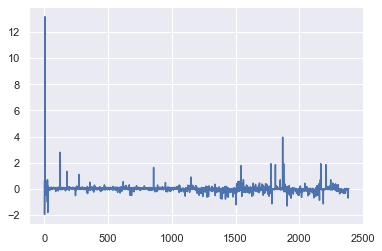

In [66]:
plt.plot(coeff)
coeff_vals = pd.DataFrame(coeff, index=X.columns, columns=['coefficient'])
coeff_vals['coefficient_abs']=np.abs(coeff_vals['coefficient'])
coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [67]:
X_sea = X[X['source_Seattle'] == 1]
y_sea = y.loc[X_sea.index]
X_bos = X[X['source_Boston'] == 1]
y_bos = y.loc[X_bos.index]
X_ber = X[X['source_Boston'] == X['source_Seattle']]
y_ber = y.loc[X_ber.index]
print(X_sea.shape, y_sea.shape, X_bos.shape, y_bos.shape, X_ber.shape, y_ber.shape)

(3171, 2390) (3171,) (2772, 2390) (2772,) (18163, 2390) (18163,)


{'model__alpha': 0.1}
Seattle:: train score: 0.2942399327103503  | test score: 0.015741458094922556
Boston::  train score: 0.37432183595662627  | test score: -0.08091547309927605
Berlin::  train score: 0.20243423390373816  | test score: -0.08010662897339871


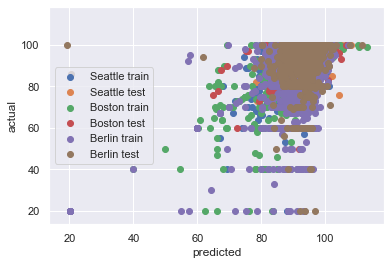

In [68]:
X_sea_train, X_sea_test, y_sea_train, y_sea_test = train_test_split(X_sea, y_sea, test_size=0.1, random_state=23 * 42)
sea_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=0.001))
])

sea_PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)
sea_PCV_f = sea_PCV.fit(X_sea_train, y_sea_train)
print(sea_PCV_f.best_params_)

X_bos_train, X_bos_test, y_bos_train, y_bos_test = train_test_split(X_bos, y_bos, test_size=0.1, random_state=23 * 42)
bos_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=sea_PCV_f.best_params_['model__alpha']))
])

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(X_ber, y_ber, test_size=0.1, random_state=23 * 42)
ber_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=sea_PCV_f.best_params_['model__alpha']))
])


sea_pipeline.fit(X_sea_train, y_sea_train)
print('Seattle:: train score: {}  | test score: {}'.format(sea_pipeline.score(X_sea_train, y_sea_train), sea_pipeline.score(X_sea_test, y_sea_test)))

bos_pipeline.fit(X_bos_train, y_bos_train)
print('Boston::  train score: {}  | test score: {}'.format(bos_pipeline.score(X_bos_train, y_bos_train), bos_pipeline.score(X_bos_test, y_bos_test)))

ber_pipeline.fit(X_ber_train, y_ber_train)
print('Berlin::  train score: {}  | test score: {}'.format(ber_pipeline.score(X_ber_train, y_ber_train), ber_pipeline.score(X_ber_test, y_ber_test)))

plt.scatter(sea_pipeline.predict(X_sea_train), y_sea_train, label='Seattle train')
plt.scatter(sea_pipeline.predict(X_sea_test), y_sea_test, label='Seattle test')
plt.scatter(bos_pipeline.predict(X_bos_train), y_bos_train, label='Boston train')
plt.scatter(bos_pipeline.predict(X_bos_test), y_bos_test, label='Boston test')
plt.scatter(ber_pipeline.predict(X_ber_train), y_ber_train, label='Berlin train')
plt.scatter(ber_pipeline.predict(X_ber_test), y_ber_test, label='Berlin test')

limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
calculated_host_listings_count,-1.500606,1.500606
availability_60,-1.486744,1.486744
host_neighbourhood_Fenway/Kenmore,-1.168987,1.168987
price,1.088717,1.088717
availability_90,1.080238,1.080238
host_neighbourhood_Eastlake,1.001407,1.001407
host_response_rate_40%,-0.992503,0.992503
zipcode_98199,0.978281,0.978281
neighbourhood_cleansed_Eastlake,-0.956843,0.956843
zipcode_98121,-0.803424,0.803424


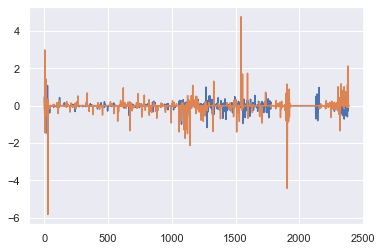

In [69]:
plt.plot(sea_pipeline.steps[-1][-1].coef_, label='Seattle')
plt.plot(bos_pipeline.steps[-1][-1].coef_, label='Boston')
sea_coeff_vals = pd.DataFrame(sea_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
sea_coeff_vals['coefficient_abs']=np.abs(sea_coeff_vals['coefficient'])
sea_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [70]:
bos_coeff_vals = pd.DataFrame(bos_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
bos_coeff_vals['coefficient_abs']=np.abs(bos_coeff_vals['coefficient'])
bos_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
calculated_host_listings_count,-5.831863,5.831863
neighbourhood_cleansed_Charlestown,4.772875,4.772875
zipcode_02129,-4.436439,4.436439
host_total_listings_count,2.986978,2.986978
host_listings_count,2.986978,2.986978
zipcode_02128,-2.701517,2.701517
host_acceptance_rate_45%,-2.131560,2.131560
calendar_updated_today,2.131516,2.131516
host_response_rate_79%,-1.748207,1.748207
neighbourhood_cleansed_Hyde Park,1.739552,1.739552


In [71]:
ber_coeff_vals = pd.DataFrame(ber_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
ber_coeff_vals['coefficient_abs']=np.abs(ber_coeff_vals['coefficient'])
ber_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
"host_location_Berlin, Berlin, Germany",2.335167,2.335167
zipcode_12524,2.116516,2.116516
latitude,1.968155,1.968155
neighbourhood_cleansed_Altglienicke,-1.796077,1.796077
host_neighbourhood_nan,-1.440220,1.440220
host_location_DE,1.320714,1.320714
neighbourhood_cleansed_Bohnsdorf,-1.236629,1.236629
host_neighbourhood_Neukölln,-1.073800,1.073800
property_type_Apartment,1.055109,1.055109
host_neighbourhood_Prenzlauer Berg,-1.021524,1.021524


In [72]:
listings['neighbourhood_cleansed'].value_counts()

Tempelhofer Vorstadt        1325
Frankfurter Allee Süd FK    1282
Alexanderplatz              1091
Reuterstraße                1002
Rixdorf                      880
                            ... 
Allende-Viertel                3
Neu-Hohenschönhausen Süd       2
Roxhill                        2
MV 2                           1
Hellersdorf-Ost                1
Name: neighbourhood_cleansed, Length: 247, dtype: int64